# 🧠 Exploring Amazon Rekognition for Face, Celebrity, Content & Text Detection
##  Amazon Rekognition Tutorial: Image & Video Intelligence with **No ML Required!** 🎥📸
# 🤖 Amazon Rekognition Deep Dive with Python 🧠

Welcome to this hands-on tutorial where we explore the powerful capabilities of **Amazon Rekognition**, AWS's cloud-based computer vision service!🚀🖼️🎥

In this notebook, you'll learn how to:
🔍 Detect **faces** and analyze facial attributes
🌟 Recognize **celebrities** in images and videos
🚫 **Content Moderation** – Flag unsafe, explicit, or violent content  
📝 **Text Detection** – Extract text from images and video frames  
🎯 **Object & Scene Detection** – Identify items and scenes in media  
🎭 **Emotion & Attribute Analysis** – Understand facial expressions and characteristics  

All examples use the official **Boto3 AWS SDK** and real use-case scenarios to help you build intelligent applications. This tutorial is perfect for developers, ML engineers, and data scientists who want to integrate cloud-based vision AI into their pipelines without training models from scratch. 🙌

## 🛠️ Technologies Used:
- Amazon Rekognition
- Boto3 (AWS SDK for Python)
- Jupyter Notebooks
- AWS S3 (for image/video storage)

✅ **What You’ll Practice**:
- Uploading and analyzing images/videos from S3
- Using Python SDK (`boto3`) to call Rekognition APIs
- Real use cases for public safety, content moderation, identity verification, and media indexing

👉 Ideal for developers, researchers, or businesses exploring scalable image/video analytics.

Let’s turn your data into vision! 👁️💻✨

---


## 🚀 Environment Setup & Initialization

In this section, we import necessary libraries, prepare directories, and set up sessions with Amazon services. This includes preparing SageMaker and making sure local storage is ready for temporary media processing.

####  Importing Required Libraries
We start by importing essential Python libraries 📦 such as `boto3` for accessing AWS services and interaction, SageMaker SDK, image display utilities, `PIL` for image processing, `matplotlib` for visualization, and `os` for file path operations.


In [1]:
import boto3
import sagemaker
from IPython.display import HTML, display, Image as IImage
from PIL import Image, ImageDraw, ImageFont
import time
import os

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


#### 🤖 Initializing Rekognition Client

Here we create a `boto3` client for Amazon Rekognition. This allows us to interact with Rekognition APIs to analyze images and videos stored in S3 or local files.
Set up SageMaker session, get default role, bucket, and region. Create Rekognition and S3 clients.

In [2]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

#Define client for Amazon Rekognition and S3
rekognition = boto3.client("rekognition")
s3 = boto3.client("s3")

#### 🗂️ Creating Temporary Directory

This command creates a local `./temp` folder where images and videos will be stored temporarily for processing with Amazon Rekognition.

In [3]:
!mkdir -p ./temp
temp_folder = "temp/"

## 🖼️ Image Display Utilities

Here we define helper function `drwBoundingBoxes` to display images and overlay bounding boxes. This function will be used to visualize detected faces, labels, and moderation outcomes returned by Rekognition. It draws bounding boxes around detected entities like faces or text using their coordinates.


In [4]:
def drwBoundingBoxes(imageFrame, boxes):
    colorsTuples = ((255, 0, 0), (0, 255, 0), (0, 0, 255), (50, 190, 120))

    # Let's store the image in the temporary local folder we created
    imageDir = temp_folder + os.path.basename(imageFrame)
    #doanload the image frame from S3
    s3.download_file(bucket, imageFrame, imageDir)

    # Draws Bounding Box on Image
    boundedImage = Image.open(imageDir)
    drw = ImageDraw.Draw(boundedImage)
    w, h = boundedImage.size #get image width, height
    color = 0
    maxColor = len(colorsTuples)
    boxLines = 3 # 4 lines: 0-3
    #box coordinates (x1, y1) and (x2, y2)
    for b in boxes:
        x1 = int(b[1]["Left"] * w)
        y1 = int(b[1]["Top"] * h)
        x2 = int(b[1]["Left"] * w + b[1]["Width"] * w)
        y2 = int(b[1]["Top"] * h + b[1]["Height"] * h)

        drw.text((x1, y1), b[0], colorsTuples[color])
        for line in range(boxLines):
            drw.rectangle((x1 - line, y1 - line, x2 + line, y2 + line), outline=colorsTuples[color])
        color = (color + 1) % maxColor

    imgFormat = "PNG"
    extension = imgFormat.lower()
    if extension.endswith("jpg") or extension.endswith("jpeg"):
        imgFormat = "JPEG"

    boundedImage.save(imageDir, format=imgFormat)

    display(boundedImage)

# Part 1: 👤 Face Detection & Analysis

Amazon Rekognition can detect faces in images and analyze attributes like age range, emotions, and pose. In this section, we will send an image to the Amazon Rekognition API and extracts insights for us 🌟

# Recognize Celebrities in Images

#### 🖼️ Loading and Displaying an Image

We fetch an image stored on S3 using a presigned URL and display it to verify that it was retrieved successfully.


In [5]:
#import and view image from directory
imageFileName = "media/mi6.png"
display(IImage(url=s3.generate_presigned_url("get_object", Params={"Bucket": bucket, "Key": imageFileName}), width=350, height=150))

#### 👁️ Detecting Faces in an Image

This cell sends the image to the Rekognition `recognize_celebrities()` API from Amazon Rekognition to identify celebritie, facial landmarks and attributes such as emotions, age range, gender, and smile. This can be useful in media, entertainment, and archival use cases.

What celebrities information returned inside JSON response:

- Name
- Id
- Urls
- Facial attributes

In [6]:
#
recognizedCelebsResponse = rekognition.recognize_celebrities(
    Image={
        "S3Object": {
            "Bucket": bucket, #default_bucket
            "Name": imageFileName, # MI6 movie shot
        }
    }
)

display(recognizedCelebsResponse)

{'CelebrityFaces': [{'Urls': ['www.wikidata.org/wiki/Q37079',
    'www.imdb.com/name/nm0000129'],
   'Name': 'Tom Cruise',
   'Id': '2zs2cs8k',
   'Face': {'BoundingBox': {'Width': 0.2653049826622009,
     'Height': 0.38085633516311646,
     'Left': 0.5444830656051636,
     'Top': 0.14110559225082397},
    'Confidence': 99.99972534179688,
    'Landmarks': [{'Type': 'eyeRight',
      'X': 0.7513101100921631,
      'Y': 0.2833847105503082},
     {'Type': 'eyeLeft', 'X': 0.6347073316574097, 'Y': 0.28749537467956543},
     {'Type': 'mouthRight', 'X': 0.7486317753791809, 'Y': 0.4209804832935333},
     {'Type': 'mouthLeft', 'X': 0.651661217212677, 'Y': 0.4247465133666992},
     {'Type': 'nose', 'X': 0.71452397108078, 'Y': 0.349712073802948}],
    'Pose': {'Roll': -0.904134213924408,
     'Yaw': 11.223363876342773,
     'Pitch': 4.4798455238342285},
    'Quality': {'Brightness': 89.47183227539062,
     'Sharpness': 89.85481262207031},
    'Emotions': [{'Type': 'CALM', 'Confidence': 55.8066444

#### 📦 Parse and Visualize Recognized Celebrities  
We extract celebrity names and their bounding box coordinates from the JSON output and visualize them on the original image using the helper function `drwBoundingBoxes` to draw bounding box around each face.

Number of Celebrities found:  2


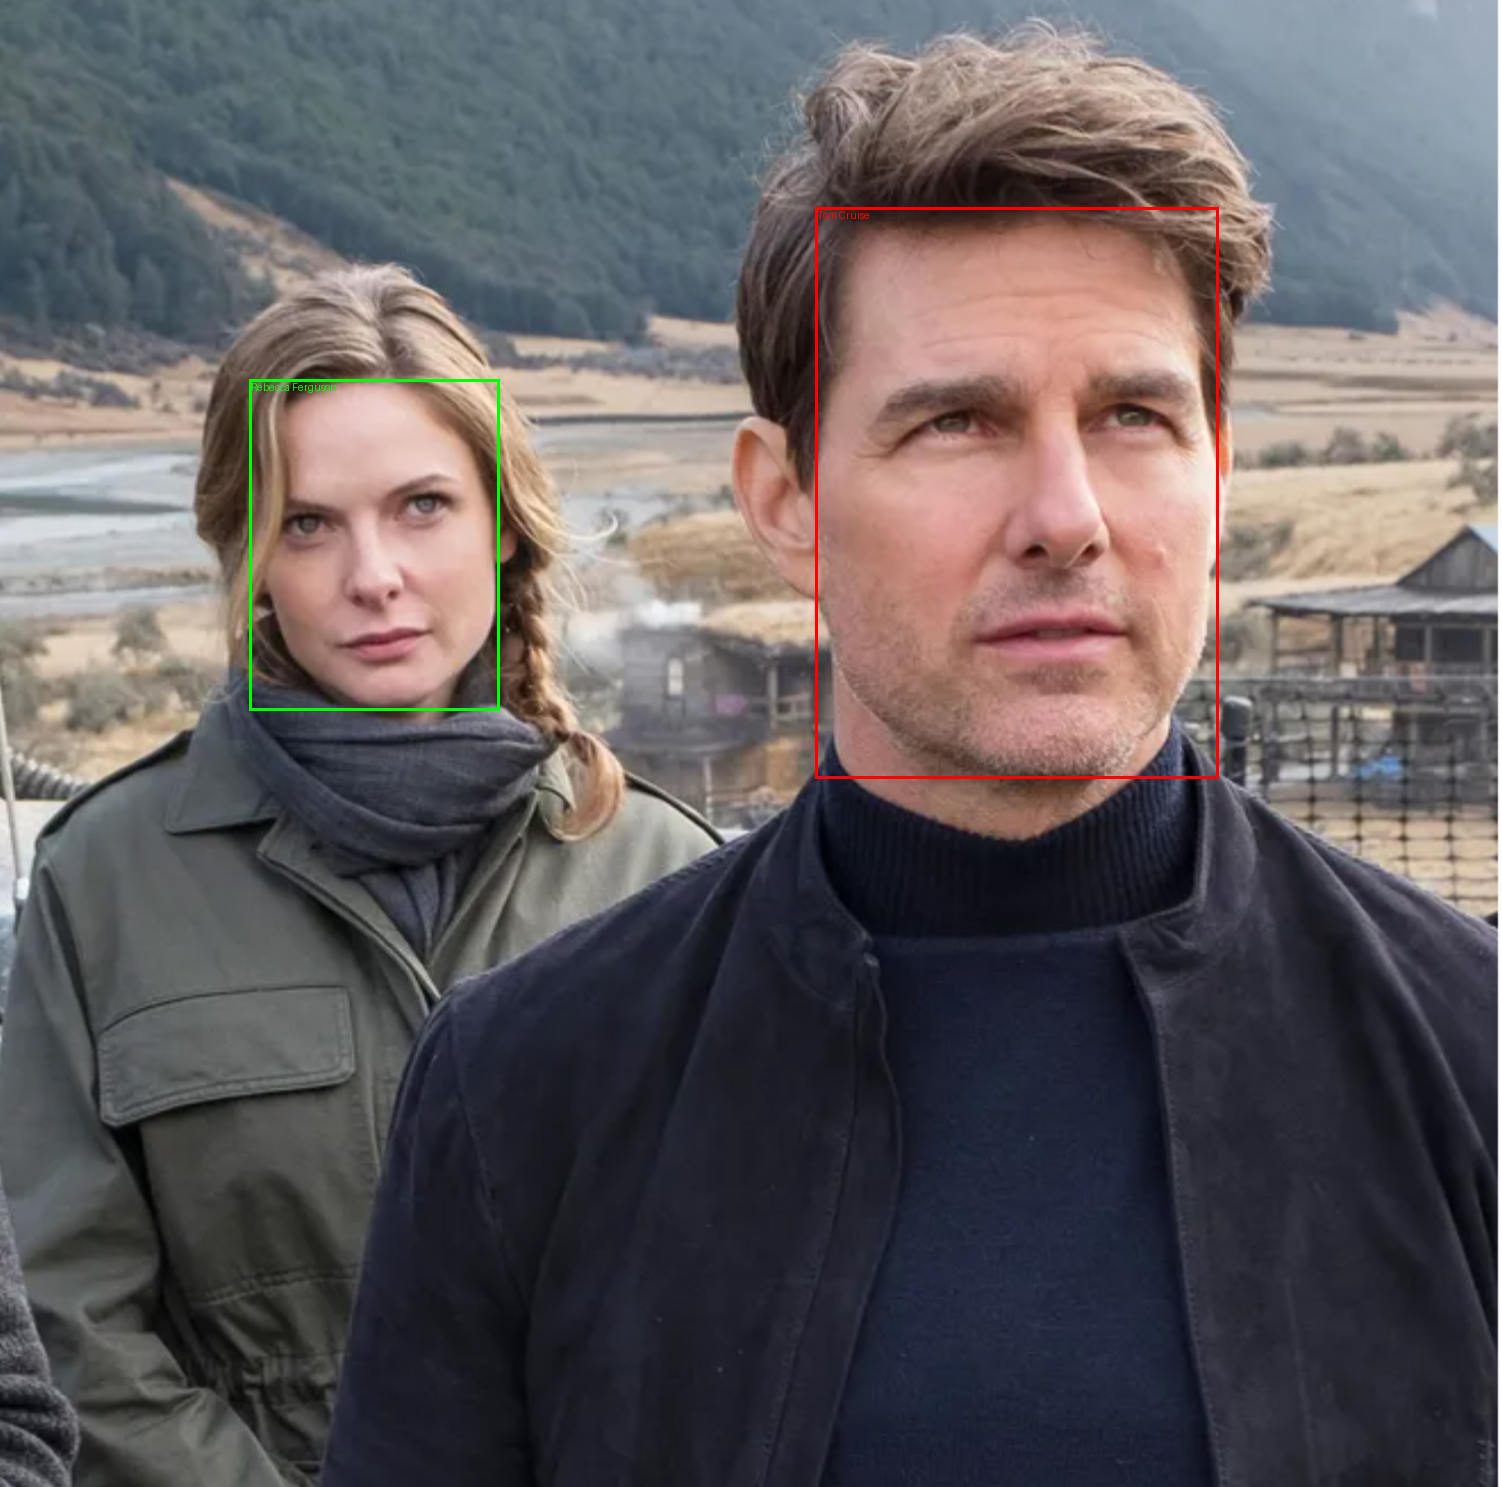

In [ ]:
boundingBoxes = []
allCelebrities = recognizedCelebsResponse["CelebrityFaces"]
for c in allCelebrities:
    boundingBoxes.append((c["Name"], c["Face"]["BoundingBox"]))
print("Number of Celebrities found: ", len(boundingBoxes))
drwBoundingBoxes(imageFileName, boundingBoxes)

### 🎞️ Display Trailer Video  
We generate and display a pre-signed S3 URL for a video to be used in video-based celebrity recognition tasks.


In [8]:
videoFileName = "media/mi6Trailer.mp4" # Our MI6 trimmed trailer 33 seconds

videoS3URL=s3.generate_presigned_url("get_object", Params={"Bucket": bucket, "Key": videoFileName})
videoHTML = "<video controls='controls' width='640' height='360' name='Video' src='{0}'></video>".format(videoS3URL)
display(HTML(videoHTML))

### 🏁 Start Celebrity Recognition Job (Video)  
Here we submit a video file for celebrity recognition via Rekognition’s asynchronous job API and retrieves the job ID using `start_celebrity_recognition`.


In [9]:
#add video word to the name
rekognitionVideoCelebJob = rekognition.start_celebrity_recognition(
    Video={
        "S3Object": {
            "Bucket": bucket,
            "Name": videoFileName,
        }
    },
)

rekognitionVideoCelebJobID = rekognitionVideoCelebJob["JobId"]
print("AWS Rekognition Job Id: {0}".format(rekognitionVideoCelebJobID))

AWS Rekognition Job Id: ce737e921120816d616c5a12c3b406b9687a62570025b387c25ee4f16678b706


#### ⏱️ Poll Rekognition Job Status (Celebrities)  
We continuously poll the celebrity recognition job until the job is marked as `SUCCEEDED`. This is essential for async processing.


In [10]:
%%time

getRecognitionCelebJob = rekognition.get_celebrity_recognition(JobId=rekognitionVideoCelebJobID, SortBy="TIMESTAMP")

while getRecognitionCelebJob["JobStatus"] == "IN_PROGRESS":
    time.sleep(5) # change time
    print("*", end="")
    getRecognitionCelebJob = rekognition.get_celebrity_recognition(JobId=rekognitionVideoCelebJobID, SortBy="TIMESTAMP")

print("Detecting Celebrities in Video: "+ getRecognitionCelebJob["JobStatus"])

************Detecting Celebrities in Video: SUCCEEDED
CPU times: user 50.2 ms, sys: 0 ns, total: 50.2 ms
Wall time: 1min


### 📤 Let's Display and Examine Celebrity Detection Results  
Here we display the raw JSON results returned after celebrity detection from the video file.


In [11]:
display(getRecognitionCelebJob)

{'JobStatus': 'SUCCEEDED',
 'VideoMetadata': {'Codec': 'h264',
  'DurationMillis': 32991,
  'Format': 'QuickTime / MOV',
  'FrameRate': 24.00633430480957,
  'FrameHeight': 800,
  'FrameWidth': 1920,
  'ColorRange': 'LIMITED'},
 'Celebrities': [{'Timestamp': 0,
   'Celebrity': {'Urls': ['www.wikidata.org/wiki/Q65054865'],
    'Name': 'Rebekah Graf',
    'Id': 'f52984',
    'Confidence': 99.88365173339844,
    'Face': {'BoundingBox': {'Width': 0.4063573181629181,
      'Height': 0.7696690559387207,
      'Left': 0.12197063118219376,
      'Top': 0.08075714111328125},
     'Landmarks': [{'Type': 'eyeLeft',
       'X': 0.26781588792800903,
       'Y': 0.5584803819656372},
      {'Type': 'eyeRight', 'X': 0.30926692485809326, 'Y': 0.26932665705680847},
      {'Type': 'mouthLeft', 'X': 0.4050126075744629, 'Y': 0.6660219430923462},
      {'Type': 'mouthRight',
       'X': 0.43896055221557617,
       'Y': 0.4232378900051117},
      {'Type': 'nose', 'X': 0.3786683976650238, 'Y': 0.44654694199562

#### 📋 Extract and Summarize Celebrity Appearances  
We parse the detection results and format them in a readable structure showing the celebrity name and time range they appeared in.


In [13]:
celebs = {}
listHeader = "List of Celebrities Detected: \n"
videoDetails =""
celebsString = ""

# All detected celebrities per frame
for celebrity in getRecognitionCelebJob["Celebrities"]:
    if "Celebrity" in celebrity:
        confidence = celebrity["Celebrity"]["Confidence"]
        if confidence > 95: #Confidence threshold
            timeStamp = celebrity["Timestamp"]
            celebName = celebrity["Celebrity"]["Name"]
            videoDetails = videoDetails + "Celebrity found at time {} ms: {} (Confidence: {})\n".format(timeStamp, celebName, round(confidence, 2))
            if not celebName in celebs:
                celebs[celebName] = celebName


# Keep only unique faces found in the clip
for celeb in celebs:
    celebsString = celebsString + "Name: {}\n".format(celeb)

# Print the results
print(listHeader)
print(celebsString)
print ("List Details:")
print(videoDetails)


List of Celebrities Detected: 

Name: Rebekah Graf
Name: Esai Morales
Name: Hayley Atwell
Name: Simon Pegg
Name: Ving Rhames
Name: Vanessa Kirby
Name: Henry Czerny
Name: Tom Cruise

List Details:
Celebrity found at time 0 ms: Rebekah Graf (Confidence: 99.88)
Celebrity found at time 499 ms: Rebekah Graf (Confidence: 99.97)
Celebrity found at time 2499 ms: Esai Morales (Confidence: 99.98)
Celebrity found at time 2999 ms: Esai Morales (Confidence: 100.0)
Celebrity found at time 3499 ms: Esai Morales (Confidence: 100.0)
Celebrity found at time 3998 ms: Hayley Atwell (Confidence: 99.99)
Celebrity found at time 4498 ms: Hayley Atwell (Confidence: 99.96)
Celebrity found at time 7997 ms: Simon Pegg (Confidence: 99.91)
Celebrity found at time 8497 ms: Simon Pegg (Confidence: 99.95)
Celebrity found at time 8997 ms: Ving Rhames (Confidence: 99.99)
Celebrity found at time 9497 ms: Rebekah Graf (Confidence: 99.88)
Celebrity found at time 14496 ms: Vanessa Kirby (Confidence: 100.0)
Celebrity found a

### 🧍 Let's Display a Local User Image 
This image will be used to test the celebrity recognition API on a locally available image of me.
Then we run Rekognition on my image to detect if any known celebrities are identified.



In [14]:
meCelebrityPicture = "media/myPicture.png" #myPicture
display(IImage(url=s3.generate_presigned_url("get_object", Params={"Bucket": bucket, "Key": meCelebrityPicture}),width=350, height=150))

In [15]:
# Call Amazon Rekognition to recognize my picture
recognizedCelebsResponse = rekognition.recognize_celebrities(
    Image={
        "S3Object": {
            "Bucket": bucket,
            "Name": meCelebrityPicture,
        }
    }
)
display(recognizedCelebsResponse)

{'CelebrityFaces': [{'Urls': ['www.wikidata.org/wiki/Q4666105'],
   'Name': 'Abdullah bin Nasser bin Khalifa Al Thani',
   'Id': 'Dp1iV6A',
   'Face': {'BoundingBox': {'Width': 0.1814693659543991,
     'Height': 0.3975597321987152,
     'Left': 0.5763143301010132,
     'Top': 0.3676845133304596},
    'Confidence': 99.99982452392578,
    'Landmarks': [{'Type': 'mouthLeft',
      'X': 0.6376269459724426,
      'Y': 0.6680607795715332},
     {'Type': 'eyeRight', 'X': 0.6893383264541626, 'Y': 0.49584636092185974},
     {'Type': 'mouthRight', 'X': 0.700444221496582, 'Y': 0.6449804306030273},
     {'Type': 'nose', 'X': 0.6524962186813354, 'Y': 0.5925363302230835},
     {'Type': 'eyeLeft', 'X': 0.6142799258232117, 'Y': 0.5238797068595886}],
    'Pose': {'Roll': -12.705315589904785,
     'Yaw': -8.424924850463867,
     'Pitch': 0.5312657356262207},
    'Quality': {'Brightness': 67.25019073486328,
     'Sharpness': 98.08562469482422},
    'Emotions': [{'Type': 'CALM', 'Confidence': 100.0},
    

#### 🚫 Draw Bounding Boxes on Unrecognized Faces  
Highlight faces found in the image that weren’t matched with any known celebrity.

In [17]:
facesBoundingBoxes = [] #
facesList = recognizedCelebsResponse["UnrecognizedFaces"]
if facesList:
    for face in facesList:
        facesBoundingBoxes.append(("Unrecognized Persons", face["BoundingBox"]))
        drwBoundingBoxes(meCelebrityPicture, facesBoundingBoxes)
else:
    display(IImage(url=s3.generate_presigned_url("get_object", Params={"Bucket": bucket, "Key": meCelebrityPicture}),width=350, height=150))

### 🚨🚨🚨 End of Part 1 🚨🚨🚨
### 🚨🚨🚨 WARNING: Don't Forget to Release Resources 🚨🚨🚨



#  Part 2: Content Moderation




### 🖼️ Display Image for Content Moderation  
We display another image from the S3 bucket, this time for content moderation tasks (i.e., detecting unsafe or explicit content).


In [16]:
imageFileName = "media/mi6arms.jpg"
display(IImage(url=s3.generate_presigned_url("get_object", Params={"Bucket": bucket, "Key": imageFileName}), width=700, height=500))

### 🚨 Detect Moderation Labels (Image)  
Call Rekognition's moderation API `detect_moderation_labels` to identify unsafe content (nudity, violence, etc.) in the selected image.

#### To Print Moderation Results:  
We iterate through moderation labels to display detected content categories and their confidence scores.



In [17]:
detectedLabelsResponse = rekognition.detect_moderation_labels(
    Image={
        "S3Object": {
            "Bucket": bucket,
            "Name": imageFileName,
        }
    }
)
display(detectedLabelsResponse)

{'ModerationLabels': [{'Confidence': 99.49430084228516,
   'Name': 'Weapons',
   'ParentName': 'Violence',
   'TaxonomyLevel': 2},
  {'Confidence': 99.49430084228516,
   'Name': 'Violence',
   'ParentName': '',
   'TaxonomyLevel': 1},
  {'Confidence': 77.40859985351562,
   'Name': 'Weapon Violence',
   'ParentName': 'Graphic Violence',
   'TaxonomyLevel': 3},
  {'Confidence': 77.40859985351562,
   'Name': 'Graphic Violence',
   'ParentName': 'Violence',
   'TaxonomyLevel': 2}],
 'ModerationModelVersion': '7.0',
 'ContentTypes': [],
 'ResponseMetadata': {'RequestId': '91c94675-53c0-4733-aafd-7bf6d6013c2b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '91c94675-53c0-4733-aafd-7bf6d6013c2b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '457',
   'date': 'Fri, 16 May 2025 14:32:20 GMT'},
  'RetryAttempts': 0}}

In [19]:

for detectedLabel in detectedLabelsResponse["ModerationLabels"]:
    print("- Label Detected: {} (Confidence: {})".format(detectedLabel["Name"], detectedLabel["Confidence"]))
    print("  - Parent Label: {}".format(detectedLabel["ParentName"]))

- Label Detected: Weapons (Confidence: 99.49430084228516)
  - Parent Label: Violence
- Label Detected: Violence (Confidence: 99.49430084228516)
  - Parent Label: 
- Label Detected: Weapon Violence (Confidence: 77.40859985351562)
  - Parent Label: Graphic Violence
- Label Detected: Graphic Violence (Confidence: 77.40859985351562)
  - Parent Label: Violence


# Let's use Amazon Rekognition for Content Moderation in Video 📹

#### First We Display Video 🎥 Contents for Moderation
Display a trailer or video clip from S3 that will be used for content moderation analysis in the following steps.

In [20]:
videoFileName = "media/mi6Trailer.mp4"

videoS3URL = s3.generate_presigned_url("get_object", Params={"Bucket": bucket, "Key": videoFileName})
videoHTML = "<video controls='controls' autoplay width='640' height='360' name='Video' src='{0}'></video>".format(videoS3URL)
display(HTML(videoHTML))

#### Start Moderation Job (Video)  
Send the selected video for moderation via Rekognition's video API `start_content_moderation` and retrieve the job ID for later polling.



In [21]:
# Start content moderation job
modVideoLabelDetectionJob = rekognition.start_content_moderation(
    Video={
        "S3Object": {
            "Bucket": bucket,
            "Name": videoFileName,
        }
    },
    MinConfidence=50.0
)

modVideoJobId = modVideoLabelDetectionJob["JobId"]
print("AWS Rekognition Job Id: {0}".format(modVideoJobId))


AWS Rekognition Job Id: 62a5dda1aefdd8ea5319ba9fd0fcc6b6226cc729db46a9ff48f6c497ac87339e


### ⏱️ Poll Moderation Job Status  
Wait and check periodically until the video moderation job is completed.


In [22]:
%%time

getModLabelId = rekognition.get_content_moderation(JobId=modVideoJobId, SortBy="TIMESTAMP")

while getModLabelId["JobStatus"] == "IN_PROGRESS":
    time.sleep(5)
    print("*", end="")
    getModLabelId = rekognition.get_content_moderation(JobId=modVideoJobId, SortBy="TIMESTAMP")
print("Detecting Moderation Labels in Video: "+ getModLabelId["JobStatus"])

****************************

KeyboardInterrupt: 

### 📤 Display Moderation Results  
Print out the full moderation results from the video for inspection.


In [23]:
display(getModLabelId)

{'JobStatus': 'IN_PROGRESS',
 'ModerationLabels': [],
 'ModerationModelVersion': '7.0',
 'JobId': '62a5dda1aefdd8ea5319ba9fd0fcc6b6226cc729db46a9ff48f6c497ac87339e',
 'Video': {'S3Object': {'Bucket': 'sagemaker-us-east-1-265313908802',
   'Name': 'media/mi6Trailer.mp4'}},
 'GetRequestMetadata': {'SortBy': 'TIMESTAMP', 'AggregateBy': 'TIMESTAMPS'},
 'ResponseMetadata': {'RequestId': 'c5645674-0842-45fc-b49c-cae5f4699d1f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c5645674-0842-45fc-b49c-cae5f4699d1f',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '323',
   'date': 'Fri, 16 May 2025 14:36:52 GMT'},
  'RetryAttempts': 0}}

### 📑 Summarize Unsafe Labels from Video  
Extract moderation labels (e.g., nudity, drugs, violence) with timestamps to understand where unsafe content appears in the video.


In [24]:
labelsObjectDict = {}
videoDetails =""
labelsString = ""

for modLabel in getModLabelId["ModerationLabels"]: #change
    timeStamp = modLabel["Timestamp"] #change
    confidence = modLabel["ModerationLabel"]["Confidence"]
    labelName = modLabel["ModerationLabel"]["Name"]
    videoDetails = videoDetails + "Moderation Label Detected at time {} ms: {} (Confidence: {})\n".format(timeStamp, labelName, round(confidence, 2))
    if labelName in labelsObjectDict:
        labelFound = labelsObjectDict[labelName]
        labelsObjectDict[labelName] = {"Name": labelName, "Count": 1 + labelFound["Count"]}
    else:
        labelsObjectDict[labelName] = {"Name": labelName, "Count": 1}

# Similar to unique faces in detecting celebrities, we need unique moderation objects
for label in labelsObjectDict: #change
    labelsString = labelsString + "Name: {}, Count: {}\n".format(label, labelsObjectDict[label]["Count"])

print("List of Moderation Labels Detected:\n")
print(videoDetails)
print("Count of Labels Detected:\n")
print(labelsString)

List of Moderation Labels Detected:


Count of Labels Detected:




### 🚨🚨🚨  End of Part 2 🚨🚨🚨
### 🚨🚨🚨 WARNING: Don't Forget to Release Resources 🚨🚨🚨




# Part 3 :  Text detection





### 🖼️ Display Poster Image for Text Detection  
Display an image containing textual content, such as posters or flyers, to be used in text detection tasks.


In [25]:
imageFileName = "media/mi6poster.jpg"
display(IImage(url=s3.generate_presigned_url("get_object", Params={"Bucket": bucket, "Key": imageFileName}), width=350, height=250))


### 🔍 Detect Text in Image  
Use Rekognition API `detect_text` to detect printed or handwritten text in the image. The JSON response includes word positions and types.


In [26]:
detectedTxtResponse = rekognition.detect_text(
    Image={
        "S3Object": {
            "Bucket": bucket,
            "Name": imageFileName,
        }
    },
    Filters={"WordFilter": {"MinConfidence": 90}}, #change to 80
)
#Review JSON reponse from AMazon Rekognition
# Can you point out detected text, confidence score, and additional information.
display(detectedTxtResponse)

{'TextDetections': [{'DetectedText': 'TOM CRUISE',
   'Type': 'LINE',
   'Id': 0,
   'Confidence': 97.8184814453125,
   'Geometry': {'BoundingBox': {'Width': 0.255859375,
     'Height': 0.0338226743042469,
     'Left': 0.365234375,
     'Top': 0.029269622638821602},
    'Polygon': [{'X': 0.365234375, 'Y': 0.029269622638821602},
     {'X': 0.62109375, 'Y': 0.029269622638821602},
     {'X': 0.62109375, 'Y': 0.06309229880571365},
     {'X': 0.365234375, 'Y': 0.06309229880571365}]}},
  {'DetectedText': 'MISSION: IMPOSSIBLE',
   'Type': 'LINE',
   'Id': 1,
   'Confidence': 100.0,
   'Geometry': {'BoundingBox': {'Width': 0.783203125,
     'Height': 0.065043605864048,
     'Left': 0.1064453125,
     'Top': 0.0715479627251625},
    'Polygon': [{'X': 0.1064453125, 'Y': 0.0715479627251625},
     {'X': 0.8896484375, 'Y': 0.0715479627251625},
     {'X': 0.8896484375, 'Y': 0.1365915685892105},
     {'X': 0.1064453125, 'Y': 0.1365915685892105}]}},
  {'DetectedText': 'FALLOUT',
   'Type': 'LINE',
   

### 📦 Draw Bounding Boxes on Detected Text  
Use bounding boxes to visualize the detected words or lines directly on the image using the helper function `drwBoundingBoxes`.


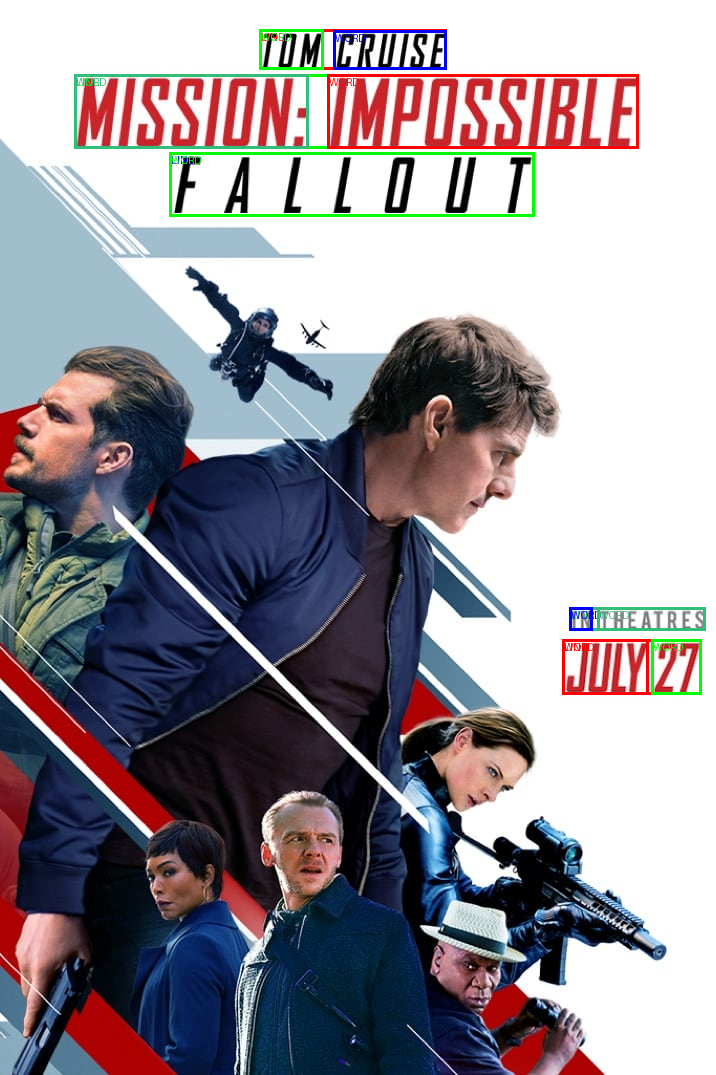

In [27]:
textBoxes = [] #change boxes
txtsDetected = detectedTxtResponse["TextDetections"]
for txtDetected in txtsDetected:
    textBoxes.append((txtDetected["Type"], txtDetected["Geometry"]["BoundingBox"]))
drwBoundingBoxes(imageFileName, textBoxes)

### 📝 Highlight Specific Keywords  
We search the detected text for specific keywords (e.g., "Tom Cruise") and print matching segments for content filtering or search applications.
Your Turn: Write code to darw bounding boxes only on wanted words



In [28]:
import string

targetWordsList = ["tom", "tom cruise", "fallout"]

for txtDetected in detectedTxtResponse["TextDetections"]:
    txt = txtDetected["DetectedText"].translate(str.maketrans("", "", string.punctuation))
    if (txtDetected["Type"] == "WORD" or txtDetected["Type"] == "LINE")  and txt.lower() in targetWordsList:
        print("Target word found: {}".format(txtDetected["DetectedText"]))

Target word found: TOM CRUISE
Target word found: FALLOUT
Target word found: TOM
Target word found: FALLOUT


### 📄 Re-run Text Detection with Filters
Re-execute the Rekognition text detection API to verify and re-extract information from the image in certain rgions or with certain confidence ....


In [29]:
# Call Amazon Rekognition to detect text in the image
# https://docs.aws.amazon.com/rekognition/latest/dg/API_DetectText.html

imageFileName = "media/mi6poster.jpg"

detectedTxtResponse = rekognition.detect_text(
    Image={
        "S3Object": {
            "Bucket": bucket,
            "Name": imageFileName,
        }
    },
    Filters={
        "WordFilter": {"MinConfidence": 90, "MinBoundingBoxHeight": 0.05, "MinBoundingBoxWidth": 0.02},
        #"RegionsOfInterest": [
        #    {"BoundingBox": {"Width": 0.1, "Height": 0.05, "Left": 0.01, "Top": 0.01}},
        #],
    },
)
# Review JSON Response from Rekognition Text API (Text Detection)
# Can you spot detected text, confidence score, and any additional information in the JSON response below
display(detectedTxtResponse)


{'TextDetections': [{'DetectedText': 'MISSION: IMPOSSIBLE',
   'Type': 'LINE',
   'Id': 0,
   'Confidence': 100.0,
   'Geometry': {'BoundingBox': {'Width': 0.783203125,
     'Height': 0.065043605864048,
     'Left': 0.1064453125,
     'Top': 0.0715479627251625},
    'Polygon': [{'X': 0.1064453125, 'Y': 0.0715479627251625},
     {'X': 0.8896484375, 'Y': 0.0715479627251625},
     {'X': 0.8896484375, 'Y': 0.1365915685892105},
     {'X': 0.1064453125, 'Y': 0.1365915685892105}]}},
  {'DetectedText': 'FALLOUT',
   'Type': 'LINE',
   'Id': 1,
   'Confidence': 99.77532958984375,
   'Geometry': {'BoundingBox': {'Width': 0.50390625,
     'Height': 0.055937498807907104,
     'Left': 0.2392578125,
     'Top': 0.14374636113643646},
    'Polygon': [{'X': 0.2392578125, 'Y': 0.14374636113643646},
     {'X': 0.7431640625, 'Y': 0.14374636113643646},
     {'X': 0.7431640625, 'Y': 0.19968385994434357},
     {'X': 0.2392578125, 'Y': 0.19968385994434357}]}},
  {'DetectedText': 'MISSION:',
   'Type': 'WORD',

### 🖨️ Print Detected Words and Lines  
List out each detected word and line with their types (WORD or LINE), useful for textual analysis or indexing.


In [30]:

for textDetection in detectedTxtResponse["TextDetections"]:
    text = textDetection["DetectedText"]
    if textDetection["Type"] == "WORD":
        print("Word: {}".format(textDetection["DetectedText"]))
    if textDetection["Type"] == "LINE":
        print("Line: {}".format(textDetection["DetectedText"]))


Line: MISSION: IMPOSSIBLE
Line: FALLOUT
Word: MISSION:
Word: IMPOSSIBLE
Word: FALLOUT


## 🎬 Can we do the same with Videos: Star Wars Introduction
We generate and display a presigned URL for a video to be used for text detection within video content.


In [31]:
videoFileName = "media/starWarsIntro.mp4"
#Again strDetails and StrOverall

videoS3URL = s3.generate_presigned_url("get_object", Params={"Bucket": bucket, "Key": videoFileName})

videoHTML = "<video controls='controls' autoplay width='640' height='360' name='Video' src='{0}'></video>".format(videoS3URL)

display(HTML(videoHTML))

### 🏁 Start Text Detection Job (Video)  
Submit a video to Rekognition’s text detection API `start_text_detection` and start the async job for extracting text from frames and then get the job id


In [32]:
startVideoTxtDetectionJob = rekognition.start_text_detection(
    Video={
        "S3Object": {
            "Bucket": bucket,
            "Name": videoFileName,
        }
    },
)
videoTextDetectionJobId = startVideoTxtDetectionJob["JobId"]
print("Amazon Rekognition Job Id: {0}".format(videoTextDetectionJobId)) #change Job Id inside and use print check all previous

Amazon Rekognition Job Id: c1ebf831422392a4b10872cbebc95ce8c05c86c501a9e79a018a943cc25c6ba3


### ⏱️ Poll Text Detection Job  
Keep checking the job status until Rekognition returns the full text detection results.


In [ ]:

getVideoTxtDetectionJob = rekognition.get_text_detection(JobId=videoTextDetectionJobId)

while getVideoTxtDetectionJob["JobStatus"] == "IN_PROGRESS":
    time.sleep(5)
    print("*", end="")

    getVideoTxtDetectionJob = rekognition.get_text_detection(JobId=videoTextDetectionJobId)

print("Amazon Rekognition Job Status: "+getVideoTxtDetectionJob["JobStatus"]) #add decorated print for the job ID

***********

### 📤 Display Text Detection Results  
Print the raw output of detected text segments from the processed video.


In [ ]:
display(getTxtDetectionJob)

### 🚩 Filter Words in Video  
We can now search for specific terms or keywords from the detected text in the video and highlight those of interest.


In [ ]:
targetText = ["POWER", "DESTROY", "SPIES", "PLANS", "EVIL", "REBEL"] #add Lord vader
txtDict = {}
detectedTextInVideo= ""
detectedTextStats =""


for textDetection in getVideoTxtDetectionJob["TextDetections"]:
    if textDetection["TextDetection"]["Type"] == "WORD":
        timeStamp = textDetection["Timestamp"]
        confidence = textDetection["TextDetection"]["Confidence"]
        detectedText = textDetection["TextDetection"]["DetectedText"]

        if detectedText in targetText:
            print("Found target text at time: {} ms: Category{} (Confidence: {})".format(timeStamp, detectedText, round(confidence, 2)))
            detectedTextInVideo = detectedTextInVideo + "Target Text Found at time {} ms: {} (Confidence: {})<br>".format(ts, detectedText, round(confidence, 2))
        if detectedText in txtDict:#You can add a condition to count only traget text ONLY
            txtFound = txtDict[detectedText]
            txtDict[detectedText] = {"Text": detectedText, "Count": 1 + txtFound["Count"]}
        else:
            txtDict[detectedText] = {"Text": detectedText, "Count": 1}

for txt in txtDict:
    detectedTextStats = detectedTextStats + "Name: {}, Count: {}\n".format(txt, txtDict[txt]["Count"])

print("List of detected target text: \n")
print(detectedTextInVideo)
print("\n\nDetected Text Statistics:\n")
print(detectedTextStats)




# 🚨🚨🚨 End of Part 3 🚨🚨🚨




In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>

<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}
</script>

In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}


# Read more from Amazon
- https://docs.aws.amazon.com/rekognition/latest/dg/celebrities.html
- https://docs.aws.amazon.com/rekognition/latest/dg/API_RecognizeCelebrities.html
- https://docs.aws.amazon.com/rekognition/latest/dg/API_StartCelebrityRecognition.html
- https://docs.aws.amazon.com/rekognition/latest/dg/API_GetCelebrityRecognition.html
- https://docs.aws.amazon.com/rekognition/latest/dg/API_DetectText.html
- https://docs.aws.amazon.com/rekognition/latest/dg/API_StartTextDetection.html
- https://docs.aws.amazon.com/rekognition/latest/dg/API_GetTextDetection.html
- https://docs.aws.amazon.com/rekognition/latest/dg/text-detecting-video-procedure.html.
